In [1]:
PATH_CHECKPOINTS = "/media/aalto-robotics/Transcend/finetuned_checkpoints/v2_checkpoints/"
PATH_DATASET_ROSBAG = "/media/aalto-robotics/Transcend/isaacsim_data/v2_test/"
PATH_DATASET_TFDS = '/media/aalto-robotics/Transcend/tensorflow_datasets/v2_test/example_dataset/1.0.0/'
PATH_INFERENCE_RESULTS = "/media/aalto-robotics/Transcend/inference_result/"

Step1: Test right dataset format

In [ ]:
# conda activate rlds_env
import rosbag
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def show_animation(messages):
    fig, ax = plt.subplots()
    im = ax.imshow(messages[0])

    def update(frame):
        im.set_array(frame)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=messages, interval=200, blit=True)
    plt.show()


bag = rosbag.Bag(PATH_DATASET_ROSBAG + 'episode_0.bag')
messages = []
for topic, msg, t in bag.read_messages(topics=['/Camera_rgb']):
   # data = msg.data
   data = np.frombuffer(msg.data, dtype=np.uint8).reshape(msg.height, msg.width, 3)
   messages.append(data)
print(len(messages))
plt.imsave(PATH_DATASET_ROSBAG + "img.png", messages[0])

messages = []
for topic, msg, t in bag.read_messages(topics=['/Camera_wrist_rgb']):
   # data = list(msg.data)
   data = np.frombuffer(msg.data, dtype=np.uint8).reshape(msg.height, msg.width, 3)
   messages.append(data)
# print(messages[0])
print(len(messages))
plt.imsave(PATH_DATASET_ROSBAG + "img_wrist.png", messages[0])
bag.close()

In [18]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

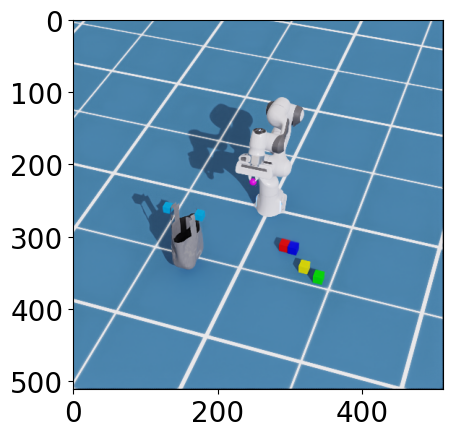

In [19]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

img = Image.open(PATH_DATASET_ROSBAG + "img.png")
img_wrist = Image.open(PATH_DATASET_ROSBAG + "img_wrist.png")
plt.imshow(img)

In [4]:
# img = np.array(img)
# img_wrist = np.array(img_wrist)
# img.shape, img_wrist.shape

((512, 512, 4), (512, 512, 4))

In [20]:
from octo.model.octo_model import OctoModel

model = OctoModel.load_pretrained(PATH_CHECKPOINTS)

In [21]:
# create obs & task dict, run inference
import jax, cv2
# add batch + time horizon 1
# img = img[np.newaxis,np.newaxis,...]
img = Image.open(PATH_DATASET_ROSBAG + "img.png")
img_wrist = Image.open(PATH_DATASET_ROSBAG + "img_wrist.png")
img = np.array(img)[..., :3]
img_wrist = np.array(img_wrist)[..., :3]
img = cv2.resize(img, (256, 256))
img = img[np.newaxis, np.newaxis, ...]
img_wrist = img_wrist[np.newaxis, np.newaxis, ...]

observation = {"image_primary": img, "image_wrist": img_wrist, "timestep_pad_mask": np.array([[True]])}
task = model.create_tasks(texts=["pick up the yellow object"])
action = model.sample_actions(
    observation, 
    task, 
    # unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"], 
    rng=jax.random.PRNGKey(0)
)
print(action)   # [batch, action_chunk, action_dim]

[[[ 2.82305211e-01  9.52217221e-01  2.51931131e-01  1.48400486e-01
   -3.54071230e-01  1.42976570e+00 -6.11335278e-01  1.29281044e+00
    1.24838293e+00]
  [ 3.14646423e-01  9.89540279e-01  2.25723147e-01  1.58253163e-01
   -4.80147243e-01  1.39098179e+00 -5.29566169e-01  1.43462610e+00
    1.43527639e+00]
  [ 3.21299762e-01  8.52238894e-01  2.08684444e-01  1.39763340e-01
   -3.37712288e-01  1.45130968e+00 -5.22274673e-01  1.35998619e+00
    1.39516091e+00]
  [ 3.79759490e-01  9.35069263e-01  1.96083397e-01  2.25029349e-01
   -5.12986600e-01  1.36228096e+00 -6.41192198e-01  1.40956378e+00
    1.30287993e+00]
  [ 2.82143384e-01  9.60734963e-01  2.79794097e-01  1.99015230e-01
   -4.88847136e-01  1.41173780e+00 -5.55404961e-01  1.48192036e+00
    1.44617820e+00]
  [ 2.91131973e-01  9.89271522e-01  1.39798969e-01  1.29630610e-01
   -5.45548439e-01  1.44005418e+00 -5.73951423e-01  1.41854048e+00
    1.30867791e+00]
  [ 1.83258712e-01  9.18437600e-01  2.57565230e-01  1.79403484e-01
   -5.483

Step 2: Run Inference on Full Trajectories

In [22]:
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

## Load Model Checkpoint
First, we will load the pre-trained checkpoint using the `load_pretrained()` function. You can specify the path to a checkpoint directory or a HuggingFace path.

Below, we are loading directly from HuggingFace.


In [12]:
from octo.model.octo_model import OctoModel

model = OctoModel.load_pretrained(PATH_CHECKPOINTS)

## Load Data
Next, we will load a trajectory from the Bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [23]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir=PATH_DATASET_TFDS)
ds = builder.as_dataset(split='train[:2]')
iterator = iter(ds)

In [24]:
episode = next(iterator)
episode

{'episode_metadata': {'file_path': <tf.Tensor: shape=(), dtype=string, numpy=b'data/train/episode_0.npy'>},
 'steps': <_VariantDataset element_spec={'action': TensorSpec(shape=(9,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'language_embedding': TensorSpec(shape=(512,), dtype=tf.float32, name=None), 'language_instruction': TensorSpec(shape=(), dtype=tf.string, name=None), 'observation': {'image': TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), 'state': TensorSpec(shape=(9,), dtype=tf.float32, name=None), 'wrist_image': TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}>}

In [25]:
# sample episode + resize to 256x256 (default third-person cam resolution)
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]
images_wrist = [np.array(step['observation']['wrist_image']) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images_wrist, fps=30)

Instruction: active block selected: YellowCube


## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [26]:
language_instruction = "pick up the yellow object and put it in the bag"

In [27]:
WINDOW_SIZE = 2

# create `task` dict
task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [28]:
# run inference loop, this model only uses 3rd person image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    input_images_wrist = np.stack(images_wrist[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'image_wrist': input_images_wrist,
        'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    
    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    actions = model.sample_actions(
        observation, 
        task, 
        unnormalization_statistics=model.dataset_statistics["action"], 
        rng=jax.random.PRNGKey(0)
    )
    actions = actions[0] # remove batch dim

    pred_actions.append(actions)
    final_window_step = step + WINDOW_SIZE - 1
    true_actions.append(
        steps[final_window_step]['action']
    )

  0%|          | 0/375 [00:00<?, ?it/s]

100%|██████████| 375/375 [26:02<00:00,  4.17s/it]  


## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

In [29]:
# calculate mean squared error
pred_actions = np.stack(pred_actions)
true_actions = np.stack(true_actions)
mse = np.mean((pred_actions[:,0,:] - true_actions) ** 2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.02920852228999138


In [30]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp', "aa", "bb"]

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([400, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()

In [ ]:
np.save(PATH_INFERENCE_RESULTS + "v1_lang_pred_actions.npy", pred_actions)